# Lab assignment: estimating housing values with regression trees

<img src="img/boston.jpg" style="width:640px;">

In this assignment we will learn how to use decision trees for regression problems. In particular, we will make use of the reference implementation in scikit-learn, and we will seek explainability on the prices of houses in Boston.

## Guidelines

Throughout this notebook you will find empty cells that you will need to fill with your own code. Follow the instructions in the notebook and pay special attention to the following symbols.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">You will need to solve a question by writing your own code or answer in the cell immediately below, or in a different file as instructed. Both correctness of the solution and code quality will be taken into account for marking.</td></tr>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">This is a hint or useful observation that can help you solve this assignment. You are not expected to write any solution, but you should pay attention to them to understand the assignment.</td></tr>
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">This is an advanced and voluntary excercise that can help you gain a deeper knowledge into the topic. This exercise won't be taken into account towards marking, but you are encouraged to undertake it. Good luck!</td></tr>
</table>

To avoid missing packages and compatibility issues you should run this notebook under one of the [recommended Ensembles environment files](https://github.com/albarji/teaching-environments-ensembles).

Lastly, if you need any help on the usage of a Python function you can place the writing curso over its name and press Shift+Tab to produce a pop-out with related documentation. This will only work inside code cells. 

Let's go!

## Preliminaries

First of all, let's fix a random seed so all results are reproducible in different runs of the notebook.

In [1]:
import numpy as np
import pandas as pd
np.random.seed(12345)

The following code will embed any plots into the notebook instead of generating a new window:

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Data preparation

For this assignment we will use the **Boston Housing** dataset. It concerns estimating the value of housing in different areas in Boston, using some geographical and societal variables as explanatory features.

### Data loading

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
 The data is contained in the file <b>boston.csv</b>. Take a look at the file format and the <b>README.md</b> description, and write the appropriate code to load all of it into a Pandas DataFrame named <b>data</b>.
 </td></tr>
</table>

<table>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
This data file is formatted as fixed-width lines. The pandas <a href=https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_fwf.html>read_fwf</a> function can help you. Note that the data file does not include column names, but they are documents in the <b>README.md</b>; you can provide them to read_fwf through the parameter <i>colnames</i>.
 </td></tr>
</table>

In [8]:
####### INSERT YOUR CODE HERE
colnames = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data = pd.read_fwf("housing.data", names = colnames)

If you have loaded the data properly, the following cell should output a table with the first 5 rows of the data:

In [9]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


### Extracting the target

Let's now extract the column that represents the quantity we want to predict (*MEDV*).

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
 Create DataFrames X, Y. The X DataFrame should contain only the explanatory variables, while the Y DataFrame must contain only the target variable <b>MEDV</b>.
 </td></tr>
</table>

In [16]:
####### INSERT YOUR CODE HERE
Y = data[["MEDV"]]
X = data.drop(columns="MEDV")

Let's check we have done this correctly:

In [17]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33


In [18]:
Y.head()

,MEDV
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2


### Splitting the data

In what follows we will use a training/test splitting of the data. We will perform that splitting now.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
 Create DataFrames <b>Xtrain</b>, <b>Ytrain</b>, <b>Xtest</b> and <b>Ytest</b>, containing approximately two thirds and one third of the available data, respectively. Make sure the corresponding X and Y DataFrames are aligned, that is, that each row of an X and its respective Y correspond to the same original data pattern.
 </td></tr>
</table>

<table>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
 You can use scikit-learn <b>train_test_split</b> function to do this easily. Note that in a regression problem it does not make sense to try to do a stratified division, so there is no need to provide that parameter.
 </td></tr>
</table>

In [23]:
####### INSERT YOUR CODE HERE
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.33)

Let's check that:

In [25]:
Xtrain.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
255,0.03548,80.0,3.64,0,0.392,5.876,19.1,9.2203,1,315.0,16.4,395.18,9.25
314,0.36920,0.0,9.90,0,0.544,6.567,87.3,3.6023,4,304.0,18.4,395.69,9.28
390,6.96215,0.0,18.10,0,0.700,5.713,97.0,1.9265,4,666.0,20.2,394.43,17.11
180,0.06588,0.0,2.46,0,0.488,7.765,83.3,2.7410,3,193.0,17.8,395.56,7.56


In [26]:
Ytrain.head()

,MEDV
3,33.4
255,20.9
314,23.8
390,15.1
180,39.8


In [27]:
Xtest.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
221,0.40771,0.0,6.20,1,0.507,6.164,91.3,3.0480,8,307.0,17.4,395.24,21.46
300,0.04417,70.0,2.24,0,0.400,6.871,47.4,7.8278,5,358.0,14.8,390.86,6.07
487,4.83567,0.0,18.10,0,0.583,5.905,53.2,3.1523,4,666.0,20.2,388.22,11.45
480,5.82401,0.0,18.10,0,0.532,6.242,64.7,3.4242,4,666.0,20.2,396.90,10.74
468,5.57570,0.0,18.10,0,0.580,5.926,71.0,2.9084,4,666.0,20.2,368.74,18.13


In [28]:
Ytest.head()

,MEDV
221,21.7
300,24.8
487,20.6
480,23.0
468,19.1


## How to create a regression tree

In scikit-learn, the machine learning library for Python, a Decision Tree for regression can be created through the DecisionTreeRegressor class:

In [29]:
from sklearn.tree import DecisionTreeRegressor

For now let's create a simple Decision Tree letting scikit-learn choose all the model parameters:

In [30]:
decisiontree = DecisionTreeRegressor()

The usage of the regression tree is exactly similar as the classification tree. For instance, the following code trains the tree on some toy data and plots it.

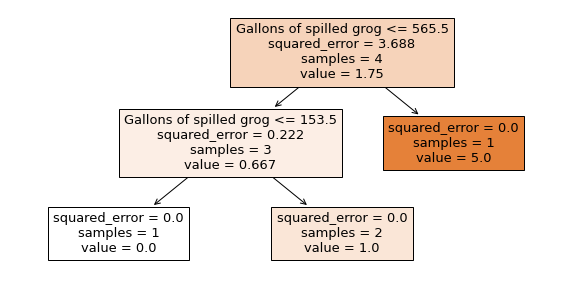

In [31]:
Xtoy = pd.DataFrame(data=[[151, 2], [219, 3], [156, 1], [912, 7]], columns=["Gallons of spilled grog", "People using R"])
ytoy = pd.DataFrame(data=[0, 1, 1, 5], columns=["Piracy crimes"])

decisiontree.fit(Xtoy, ytoy)

from sklearn.tree import plot_tree

plt.figure(figsize=(10,5))
plot_tree(decisiontree, feature_names=Xtoy.columns, filled=True)
plt.show()

Note how for a regression tree the Mean Squared Error (MSE) is used as impurity function instead of the usual Gini value for classification trees.

## Analyzing house prices

We will now make use of a Regression Tree to obtain an estimator of house prices in Boston areas. We will also learn something about the factors that influence most the prices.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
 Create a new Regression Tree and fit it on the training data. Adjust the tree depth parameter to obtain an interpretable visualization of the tree. Which variables are more relevant in predicting the price? What level of R score can you achieve in the test set? (this is the score returned by the tree <b>score</b> method
 </td></tr>
</table>

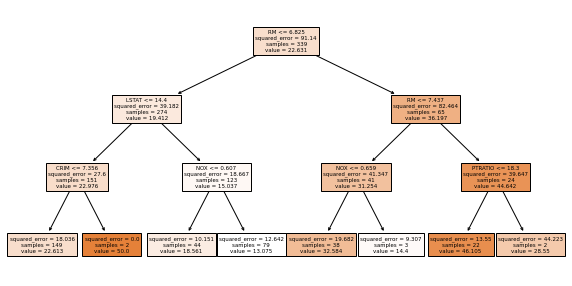

0.8286168970926356


In [41]:
####### INSERT YOUR CODE HERE
decisiontree = DecisionTreeRegressor(max_depth = 3)
decisiontree.fit(Xtrain, Ytrain)
plt.figure(figsize=(10,5))
plot_tree(decisiontree, feature_names=Xtrain.columns, filled=True)
plt.show()
print(decisiontree.score(Xtrain, Ytrain))


### Optimizing the model

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
 Run a GridSearchCV crossvalidation to find the best tree parameters over the training data. Consider both pre-pruning and post-pruning techniques, as well as different impurity criteria. What level of R score can you achieve? (this is the score returned by the tree <b>score</b> method. Which variables are more relevant in the resultant tree?
 </td></tr>
</table>

C:\Anaconda3\envs\ensembles-labs\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(


0.8286168970926356


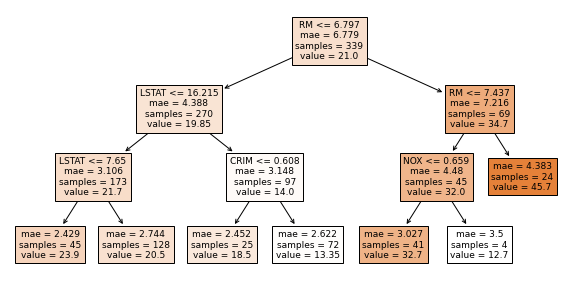

In [42]:
####### INSERT YOUR CODE HERE
from sklearn.model_selection import GridSearchCV
param_grid = {
    "criterion" : ["squared_error", "friedman_mse", "mae"],
    "max_depth": [1, 2, 3, 4, 5, 6],
    "min_samples_split": [ 2, 5, 10, 20],
    "min_samples_leaf": [2, 5, 10, 20],
    "min_impurity_decrease": [1e-3, 1e-2, 1e-1],
    "ccp_alpha": [0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
}

treesearch = GridSearchCV(
    estimator = DecisionTreeRegressor(), 
    param_grid = param_grid,
    n_jobs=-1
)

treesearch.fit(Xtrain, Ytrain)
print(decisiontree.score(Xtrain, Ytrain))
plt.figure(figsize=(10,5))
plot_tree(treesearch.best_estimator_, feature_names=Xtrain.columns, filled=True)
plt.show()

